# Predicting heart rate during excercise with LSTM

Training a LSTM model by reading decoded fit files. Inputs from the previous 60sec are:
- heart rate
- cadence
- speed
- altitude


In [1]:
# load libraries
import os, glob 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import BatchNormalization
 
fit_path = "/home/riku/projects/athlet_hr_predict/fit_file_csv"
os.chdir(fit_path)

In [2]:
# set parameters, file names
n_X = 60 # number of timesteps for training
n_y = 30 # number of timesteps in future for prediction
step = 1
batch_size = 10
epochs = 50
learning_rate = 0.001
sequence_length = int(n_X/step)
n_fit_files_test_set = 1 # number of files for testing dataset

train_files = glob.glob("*.csv")[0:-n_fit_files_test_set]
valid_files = glob.glob("*.csv")[-n_fit_files_test_set:]

In [3]:
# calculate the data normalisation parameters from all training data

def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    #return (data - data_mean) / data_std, data_mean, data_std
    return data_mean, data_std

li = []

for file in train_files:
    df = pd.read_csv(fit_path+'/'+file, index_col='timestamp')[["heart_rate", "cadence","enhanced_speed","enhanced_altitude"]]
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

df_mean, df_std = normalize(df)

def denormalize_hr(data):
    return data*df_std[0]+df_mean[0] 

## short EDA

The fit file chosen here represents a hilly run and it shows large variability during the workout in heart rate, speed and altitude. Cadence is relatively constant throughout the excercise.

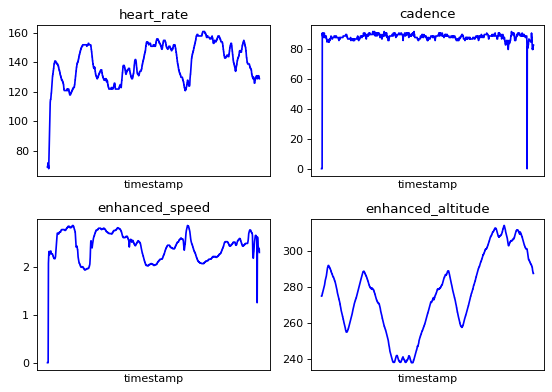

In [4]:
eda_example = pd.read_csv(fit_path+'/RUN_2021-08-26-07-15-23.fit.csv', index_col='timestamp')[["heart_rate", "cadence","enhanced_speed","enhanced_altitude"]]

def show_raw_visualization(data):
    time_data = data.index
    fig, axes = plt.subplots(
        nrows=2, ncols=2, figsize=(7, 5), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(4):
        key = ["heart_rate", "cadence","enhanced_speed","enhanced_altitude"][i]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color='b',
            title="{}".format(key),
            rot=25,
        )
        ax.set_xticks([])
    plt.tight_layout()

show_raw_visualization(eda_example)


## Feature engineering

additional feature is created, the difference of altitude between the timesteps.

In [5]:

df['alt_difference'] = df['enhanced_altitude'] - df['enhanced_altitude'].shift(1)
df

,heart_rate,cadence,enhanced_speed,enhanced_altitude,alt_difference
0,86,63,1.474,16.6,NaN
1,86,63,1.568,16.6,0.0
2,87,63,1.549,16.6,0.0
3,87,0,1.549,16.6,0.0
4,87,0,1.866,16.6,0.0
...,...,...,...,...,...
10093,132,83,2.641,286.0,-0.2
10094,131,84,2.650,286.0,0.0
10095,131,84,2.669,285.8,-0.2
10096,131,84,2.678,285.8,0.0


## Create validation dataset

In [6]:
# validation dataset - train each file at the time

for file in train_files:
    df = pd.read_csv(fit_path+'/'+file, index_col='timestamp')[["heart_rate", "cadence","enhanced_speed","enhanced_altitude"]]
    df = (df - df_mean) / df_std
    start = n_X + n_y
    end = n_X + len(df.index)
    
    x = df[["heart_rate", "cadence","enhanced_speed","enhanced_altitude"]].values
    y = df.iloc[start:end][["heart_rate"]]
    
    dataset_val = keras.preprocessing.timeseries_dataset_from_array(
        x,
        y,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=batch_size,
    )

2021-09-14 15:49:37.292981: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-14 15:49:37.296880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-14 15:49:37.297155: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-14 15:49:37.297588: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Build the model

In [7]:
# get the shapes of X & y for a batch
for batch in dataset_val.take(1):
    inputs, targets = batch

# the model
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(4, return_sequences=True)(inputs)
lstm_out = keras.layers.LSTM(2)(lstm_out)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)


2021-09-14 15:49:37.858991: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 4)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 60, 4)             144       
_________________________________________________________________
lstm_1 (LSTM)                (None, 2)                 56        
_________________________________________________________________
dense (Dense)                (None, 1)                 3         
Total params: 203
Trainable params: 203
Non-trainable params: 0
_________________________________________________________________


## Load the training data, train the model file by file

Each file is processed separately, and training epochs repeated as long as the model improves for each model up to the variable $epochs$ defined earlier. 

In [8]:
# training dataset, and train each file at the time

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

for file in train_files:
    df = pd.read_csv(fit_path+'/'+file, index_col='timestamp')[["heart_rate", "cadence","enhanced_speed","enhanced_altitude"]]
    df = (df - df_mean) / df_std
    print(file)
    start = n_X + n_y
    end = n_X + len(df.index)
    
    x = df[["heart_rate", "cadence","enhanced_speed","enhanced_altitude"]].values
    y = df.iloc[start:end][["heart_rate"]].values
    
    dataset_train = keras.preprocessing.timeseries_dataset_from_array(
        x,
        y,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=batch_size,
    )
    
    history = model.fit(
        dataset_train,
        epochs=epochs,
        validation_data=dataset_val,
        callbacks=[es_callback, modelckpt_callback],
        verbose=0
    )

    #visualize_loss(history, "Training and Validation Loss")


RUN_2021-09-01-09-09-44.fit.csv


2021-09-14 15:49:40.616817: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100



Epoch 00001: val_loss improved from inf to 0.68516, saving model to model_checkpoint.h5

Epoch 00002: val_loss improved from 0.68516 to 0.63779, saving model to model_checkpoint.h5

Epoch 00003: val_loss improved from 0.63779 to 0.63762, saving model to model_checkpoint.h5

Epoch 00004: val_loss improved from 0.63762 to 0.63613, saving model to model_checkpoint.h5

Epoch 00005: val_loss improved from 0.63613 to 0.63611, saving model to model_checkpoint.h5

Epoch 00006: val_loss improved from 0.63611 to 0.63495, saving model to model_checkpoint.h5

Epoch 00007: val_loss improved from 0.63495 to 0.63146, saving model to model_checkpoint.h5

Epoch 00008: val_loss improved from 0.63146 to 0.62689, saving model to model_checkpoint.h5

Epoch 00009: val_loss improved from 0.62689 to 0.62015, saving model to model_checkpoint.h5

Epoch 00010: val_loss improved from 0.62015 to 0.61267, saving model to model_checkpoint.h5

Epoch 00011: val_loss did not improve from 0.61267

Epoch 00012: val_loss

## Visualise the training for the last file

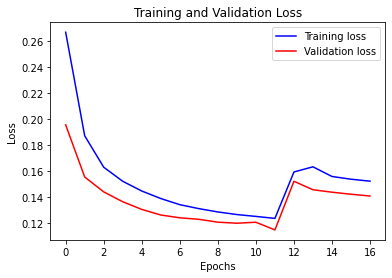

In [9]:
visualize_loss(history, "Training and Validation Loss")

## Check the model predictions visually

In [10]:
    df_test = pd.read_csv(fit_path+'/../RUN_2021-08-05-11-12-41.fit.csv', index_col='timestamp')[["heart_rate", "cadence","enhanced_speed","enhanced_altitude"]]
    df_test = (df_test - df_mean) / df_std
   
    x = df_test[["heart_rate", "cadence","enhanced_speed","enhanced_altitude"]].values
    y = df_test.iloc[n_X:end][["heart_rate"]].values

    dataset_test = keras.preprocessing.timeseries_dataset_from_array(
    x,
    y,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=120)

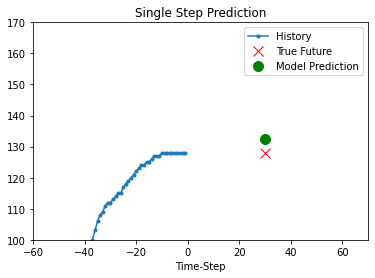

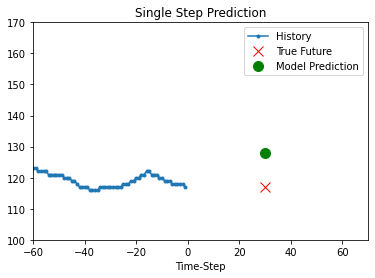

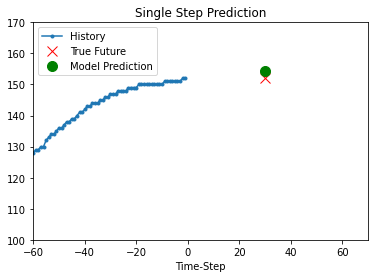

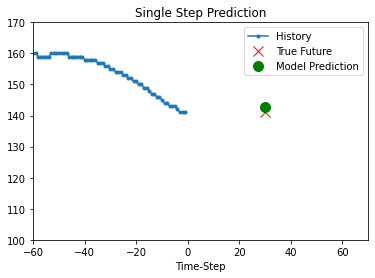

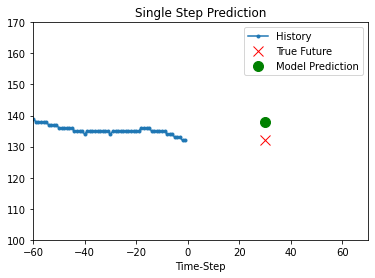

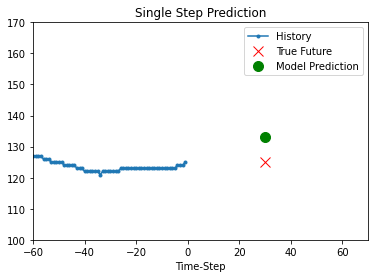

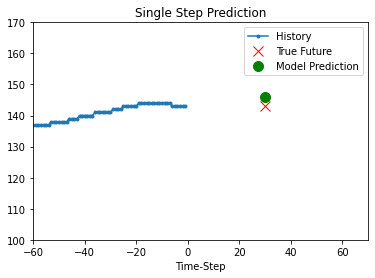

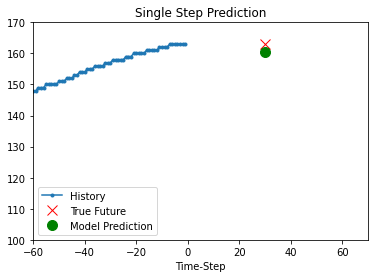

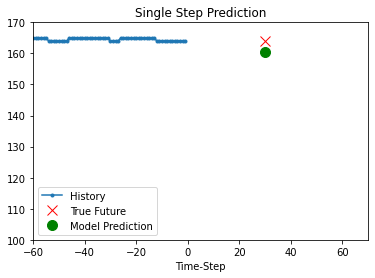

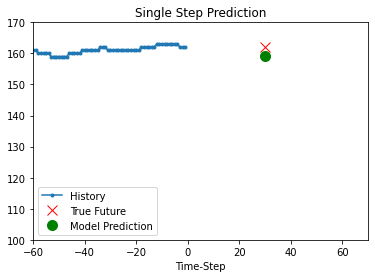

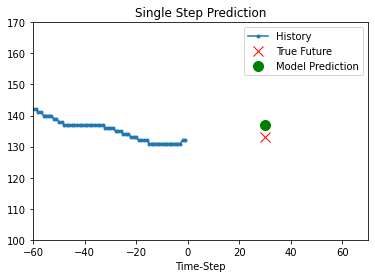

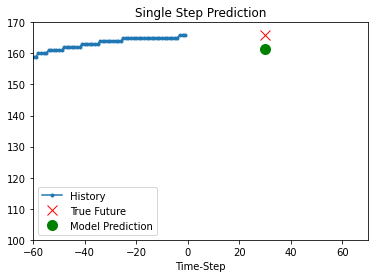

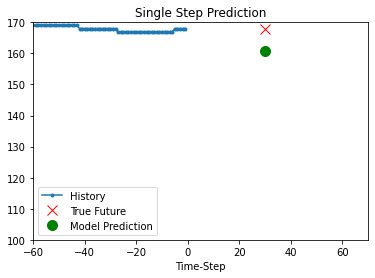

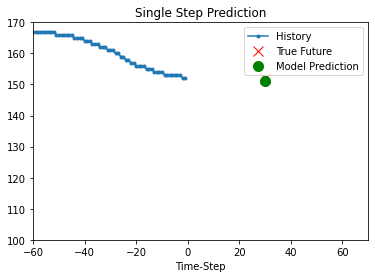

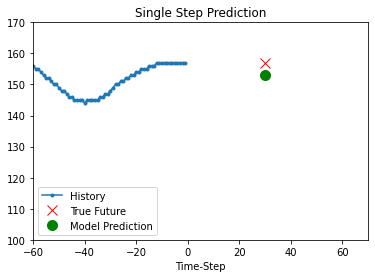

In [11]:


def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0
    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.ylim(100,170)
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_test.take(15):
    show_plot(
        [denormalize_hr(x[0][:, 0].numpy()), denormalize_hr(y[0]), denormalize_hr( model.predict(x)[0])],
        30,
        "Single Step Prediction",
    )